# Figure1

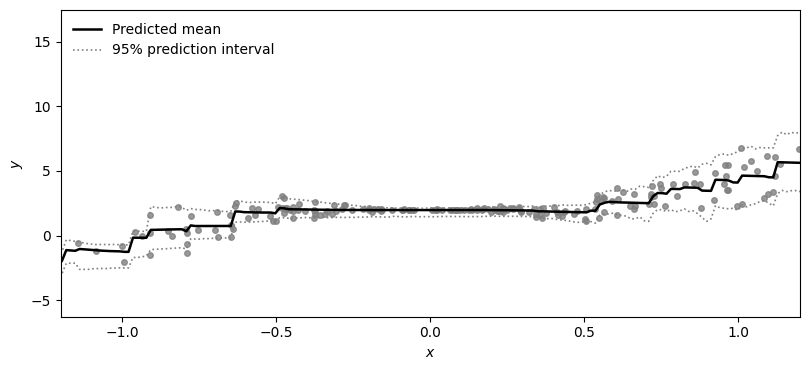

In [28]:
# Anchor–MoE toy demo (SMOOTHER VERSION)
# - Smoother anchor (GBDT: depth=2, smaller lr)
# - Soft top-k gating at inference (eps smoothing)
# - Thinner lines in plot

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ------------------ Repro & device ------------------
SEED = 7
rng = np.random.RandomState(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOG2PI = float(np.log(2 * np.pi))

# ------------------ Synthetic 1D data ------------------
# ------------------ Synthetic 1D data (central concentration) ------------------
# ------------------ Mean with a central plateau ------------------
# 平台位置与斜率（可按需微调）
l, r = -0.5, 0.5          # 平台区间 [l, r]
mu0 = 2                # 平台高度
kL, kR = 5, 5       # 左/右两侧斜率

# 分段连续的均值（两端线性 | 中间平台）
true_mean = np.where(
    x < l,
    mu0 + kL * (x - l),                 # 左侧线性段
    np.where(
        x <= r,
        mu0,                            # 中间平台
        mu0 + kR * (x - r)              # 右侧线性段
    )
).astype(np.float32)

# ------------------ Heteroscedastic noise (small center, larger tails) ------------------
# 尾部更早开始、更强烈
sigma = (
    0.01
    + 1.2 * np.clip(np.abs(x) - 0.1, 0, None)   # ↑系数从 0.10 -> 0.20，阈值从 0.8 -> 0.6
    + 1.2 * np.clip(np.abs(x) - 1.1, 0, None)   # ↑系数从 0.06 -> 0.12，阈值从 2.0 -> 1.6
).astype(np.float32)

# 观测
y = true_mean + rng.normal(0.0, sigma, size=(n, 1))

# 排序（为了更平滑的可视化）
ord_idx = np.argsort(x[:, 0])
x, y, true_mean, sigma = x[ord_idx], y[ord_idx], true_mean[ord_idx], sigma[ord_idx]

# ------------------ Smoother Anchor (GBDT) ------------------
Xtr, Xva, ytr, yva = train_test_split(x, y.ravel(), test_size=0.2, random_state=SEED)
gbdt_full = GradientBoostingRegressor(
    n_estimators=2600, learning_rate=0.03, max_depth=2, subsample=1.0, random_state=SEED
).fit(Xtr, ytr)
rmse_path = [np.sqrt(mean_squared_error(yva, p)) for p in gbdt_full.staged_predict(Xva)]
best_it = int(np.argmin(rmse_path)) + 1
gbdt_anchor = GradientBoostingRegressor(
    n_estimators=best_it, learning_rate=0.03, max_depth=2, subsample=1.0, random_state=SEED
).fit(x, y.ravel())
mu_anchor = gbdt_anchor.predict(x).astype(np.float32)

# ------------------ Utils ------------------
def _topk_mask(w, k=2):
    _, topi = torch.topk(w, k, dim=-1)
    mask = torch.zeros_like(w).scatter_(-1, topi, 1.0)
    w2 = w * mask
    return w2 / (w2.sum(dim=-1, keepdim=True) + 1e-12)

def _topk_mask_smooth(w, k=2, eps=0.25):
    # convex combo of normalized top-k and uniform over the top-k set
    _, topi = torch.topk(w, k, dim=-1)
    mask = torch.zeros_like(w).scatter_(-1, topi, 1.0)
    w_top = w * mask
    w_top = w_top / (w_top.sum(dim=-1, keepdim=True) + 1e-12)
    return (1.0 - eps) * w_top + (eps / k) * mask

# ------------------ Anchor–MoE (no router) ------------------
class Projection(nn.Module):
    def __init__(self, d, D):
        super().__init__()
        self.fc = nn.Linear(d, D)
        nn.init.xavier_uniform_(self.fc.weight); nn.init.zeros_(self.fc.bias)
    def forward(self, X): return self.fc(X)

class Window(nn.Module):
    def __init__(self, K, D, min_log_s=-2.0, max_log_s=1.0):
        super().__init__()
        self.c = nn.Parameter(torch.randn(K, D))
        self.log_s = nn.Parameter(torch.zeros(K, D))
        self.min_log_s, self.max_log_s = min_log_s, max_log_s
    def forward(self, z):
        log_s = torch.clamp(self.log_s, self.min_log_s, self.max_log_s)
        diff2 = ((z[:, None] - self.c)**2) / (2 * torch.exp(log_s)**2)
        return torch.exp(-diff2.sum(dim=-1)) + 1e-12  # [B,K]

class ExpertMDN(nn.Module):
    def __init__(self, d, h, C, sigma_min=5e-2, sigma_max=1.2, learn_mean=True):
        super().__init__()
        self.learn_mean = learn_mean
        self.net = nn.Sequential(nn.Linear(d, h), nn.ReLU(),
                                 nn.Linear(h, h), nn.ReLU())
        self.logits = nn.Linear(h, C)
        if learn_mean:
            self.means = nn.Linear(h, C)
        self.log_sc = nn.Linear(h, C)
        self.sigma_min = float(sigma_min); self.sigma_max = float(sigma_max)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, X):
        h = self.net(X)
        pi = F.softmax(self.logits(h), dim=-1)
        mu = self.means(h) if self.learn_mean else None
        sg = torch.exp(self.log_sc(h)).clamp(self.sigma_min, self.sigma_max)
        return pi, mu, sg

class AnchorMoE(nn.Module):
    def __init__(self, d, D=2, K=6, h=64, C=3, topk=2, sigma_min=5e-2, sigma_max=1.2, delta_l2=3e-3,
                 eval_soft_eps=0.25):
        super().__init__()
        self.proj = Projection(d, D)
        self.win  = Window(K, D)
        self.exps = nn.ModuleList([ExpertMDN(d, h, C, sigma_min, sigma_max, learn_mean=True) for _ in range(K)])
        self.K, self.C, self.topk = K, C, topk
        self.delta_l2 = delta_l2
        self.eval_soft_eps = eval_soft_eps  # <-- smoothness at inference

    def gate(self, z, train=True):
        w = self.win(z)
        w = w / (w.sum(dim=-1, keepdim=True) + 1e-12)
        if train:
            # slight smoothing during training
            _, topi = torch.topk(w, self.topk, dim=-1)
            mask = torch.zeros_like(w).scatter_(-1, topi, 1.0)
            w = 0.9 * (w * mask) / (w * mask).sum(dim=-1, keepdim=True) + 0.1 * mask / self.topk
        else:
            # SOFT top-k at inference for smoother curves
            w = _topk_mask_smooth(w, self.topk, eps=self.eval_soft_eps)
        return w

    def mixture_params(self, X, train=True):
        z = self.proj(X)
        w = self.gate(z, train=train)
        B, K, C = X.size(0), self.K, self.C
        Pi = torch.full((B, K, C), 1.0/C, device=X.device)
        Mu = torch.zeros(B, K, C, device=X.device)
        Sg = torch.ones(B, K, C, device=X.device)
        _, topi = torch.topk(w, self.topk, dim=-1)
        uniq = torch.unique(topi)
        for j in uniq.tolist():
            pi_j, mu_j, sg_j = self.exps[j](X)
            Pi[:, j, :] = pi_j; Mu[:, j, :] = mu_j; Sg[:, j, :] = sg_j
        return w, Pi, Mu, Sg, z

    def nll(self, X, y, mu_anchor):
        w, Pi, Mu, Sg, _ = self.mixture_params(X, train=self.training)
        Mu_eff = Mu + mu_anchor[:, None, None]
        yv = y[:, None, None]
        logp = -0.5 * ((yv - Mu_eff)/Sg)**2 - torch.log(Sg) - 0.5*LOG2PI
        logmix = torch.logsumexp(torch.log(Pi + 1e-12) + torch.log(w[:, :, None] + 1e-12) + logp, dim=(1,2))
        nll = -logmix.mean()
        nll = nll + self.delta_l2*(Mu**2).mean() + 1e-4*(self.win.log_s**2).mean()
        return nll

    @torch.no_grad()
    def mean_var(self, X, mu_anchor):
        w, Pi, Mu, Sg, _ = self.mixture_params(X, train=False)
        Mu_eff = Mu + mu_anchor[:, None, None]
        mu_e = (Pi * Mu_eff).sum(dim=2)
        m2_e = (Pi * (Sg**2 + Mu_eff**2)).sum(dim=2)
        mu = (w * mu_e).sum(dim=1)
        second = (w * m2_e).sum(dim=1)
        var = torch.clamp(second - mu**2, min=1e-9)
        return mu, var

    @torch.no_grad()
    def sample_quantiles(self, X, mu_anchor, q=(0.025, 0.975), n_samples=500):
        w, Pi, Mu, Sg, _ = self.mixture_params(X, train=False)
        Mu_eff = Mu + mu_anchor[:, None, None]
        B, K, C = Mu.shape
        mix_w  = (w[:, :, None] * Pi).reshape(B, K*C)
        mix_mu = Mu_eff.reshape(B, K*C)
        mix_sg = Sg.reshape(B, K*C)
        mix_w = mix_w / (mix_w.sum(-1, keepdim=True) + 1e-12)

        u = torch.rand(B, n_samples, device=X.device)
        cdf = torch.cumsum(mix_w, dim=1)
        idx = (cdf.unsqueeze(-1) >= u.unsqueeze(1)).float().argmax(dim=1)
        mu_pick = torch.gather(mix_mu, 1, idx)
        sg_pick = torch.gather(mix_sg, 1, idx)
        samples = mu_pick + sg_pick * torch.randn_like(mu_pick)
        return [torch.quantile(samples, q=qq, dim=1) for qq in q]

# Prepare tensors (augment x with anchor)
X_aug = np.column_stack([x.astype(np.float32), mu_anchor])
X_aug_t = torch.tensor(X_aug, device=DEVICE)
y_t = torch.tensor(y.ravel().astype(np.float32), device=DEVICE)
mu_anchor_t = torch.tensor(mu_anchor, device=DEVICE)

# Init & train
model = AnchorMoE(d=X_aug.shape[1], D=2, K=6, h=64, C=3, topk=2, eval_soft_eps=0.30).to(DEVICE)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=3e-4)
EPOCHS = 350
for ep in range(1, EPOCHS+1):
    model.train(); opt.zero_grad()
    loss = model.nll(X_aug_t, y_t, mu_anchor_t)
    loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 2.0); opt.step()

# Dense grid
xg = np.linspace(x.min(), x.max(), 300, dtype=np.float32).reshape(-1, 1)
mu_anchor_g = gbdt_anchor.predict(xg).astype(np.float32)
Xg_aug = np.column_stack([xg, mu_anchor_g])
Xg_aug_t = torch.tensor(Xg_aug, device=DEVICE)
mu_anchor_g_t = torch.tensor(mu_anchor_g, device=DEVICE)

# Predict mean + 95% interval
model.eval()
with torch.no_grad():
    mu_pred, _ = model.mean_var(Xg_aug_t, mu_anchor_g_t)
    q_lo, q_hi = model.sample_quantiles(Xg_aug_t, mu_anchor_g_t, q=(0.025, 0.975), n_samples=600)
mu_pred = mu_pred.cpu().numpy()
q_lo = q_lo.cpu().numpy()
q_hi = q_hi.cpu().numpy()

# ------------------ Plot (thinner & smooth-looking) ------------------
plt.figure(figsize=(8.2, 3.8))
plt.scatter(x[:, 0], y[:, 0], s=16, color="gray", alpha=0.8)
plt.plot(xg[:, 0], mu_pred, linewidth=1.8, color="black", label="Predicted mean")   # thinner
plt.plot(xg[:, 0], q_lo, linestyle=":", linewidth=1.2, color="gray", label="95% prediction interval")
plt.plot(xg[:, 0], q_hi, linestyle=":", linewidth=1.2, color="gray")
plt.xlim(-1.2, 1.2)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.savefig("anchor_moe_toy.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

# Figure 4


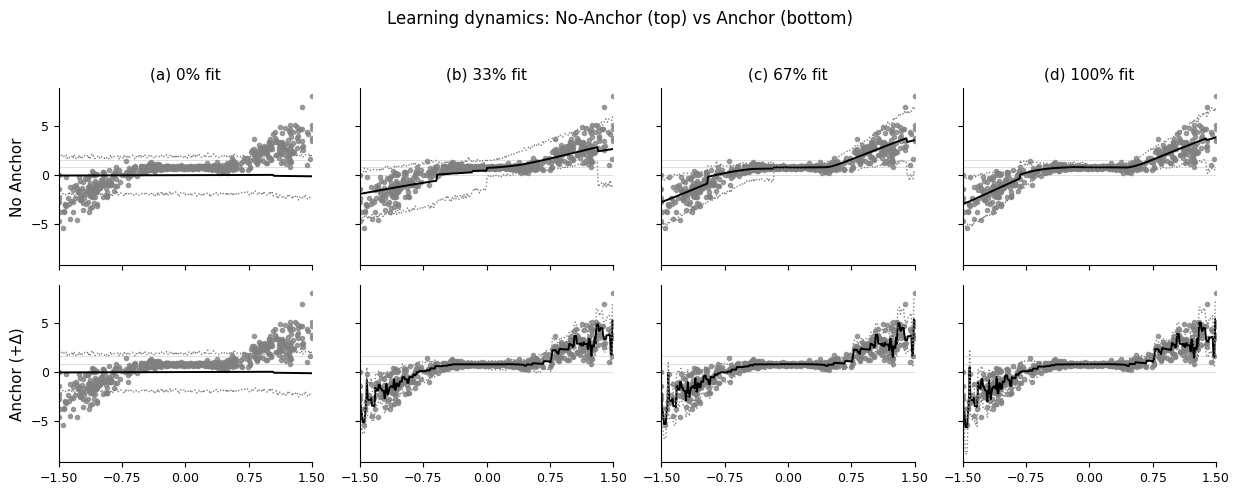

In [32]:
# ============================================================
# Anchor–MoE: Learning dynamics (No-Anchor vs Anchor) — 2×4 grid
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ---------- Repro & device ----------
SEED = 7
rng = np.random.RandomState(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOG2PI = float(np.log(2*np.pi))

# ---------- Synthetic 1D data: central plateau + heavier tails ----------
n = 700
# 中间更密集、两端稀疏的 x
mix_w = np.array([0.2, 0.6, 0.2])
mix_mu = np.array([-1.1, 0.0, 1.1])
mix_sd = np.array([0.22, 0.35, 0.22])
comp = rng.choice(3, size=n, p=mix_w)
x = (rng.normal(mix_mu[comp], mix_sd[comp])).astype(np.float32)
x = np.clip(x, -1.5, 1.5).reshape(-1, 1)

# 平台均值：左/右线性 + 中间平台
l, r = -0.5, 0.5
mu0 = 0.8
kL, kR = 3.5, 3.5
true_mean = np.where(
    x[:,0] < l, mu0 + kL*(x[:,0]-l),
    np.where(x[:,0] <= r, mu0, mu0 + kR*(x[:,0]-r))
).astype(np.float32)

# 异方差噪声：中间小、两端大
sigma = (0.06
         + 0.9*np.clip(np.abs(x[:,0]) - 0.2, 0, None)
         + 0.7*np.clip(np.abs(x[:,0]) - 1.0, 0, None)).astype(np.float32)

y = true_mean + rng.normal(0.0, sigma)

# 给可视化用的排序
ord_idx = np.argsort(x[:,0])
x, y, true_mean, sigma = x[ord_idx], y[ord_idx], true_mean[ord_idx], sigma[ord_idx]

# ---------- Anchor via GBDT (用于 Anchor 分支；No-Anchor 分支会传零向量) ----------
Xtr, Xva, ytr, yva = train_test_split(x, y, test_size=0.2, random_state=SEED)
gbdt_full = GradientBoostingRegressor(
    n_estimators=2600, learning_rate=0.03, max_depth=2, subsample=1.0, random_state=SEED
).fit(Xtr, ytr)
rmse_path = [np.sqrt(mean_squared_error(yva, p)) for p in gbdt_full.staged_predict(Xva)]
best_it = int(np.argmin(rmse_path)) + 1
gbdt_anchor = GradientBoostingRegressor(
    n_estimators=best_it, learning_rate=0.03, max_depth=2, subsample=1.0, random_state=SEED
).fit(x, y)
mu_anchor = gbdt_anchor.predict(x).astype(np.float32)

# ---------- Utilities ----------
def _topk_mask_smooth(w, k=2, eps=0.25):
    _, topi = torch.topk(w, k, dim=-1)
    mask = torch.zeros_like(w).scatter_(-1, topi, 1.0)
    w_top = (w * mask)
    w_top = w_top / (w_top.sum(dim=-1, keepdim=True) + 1e-12)
    return (1.0 - eps) * w_top + (eps / k) * mask

# ---------- MoE blocks ----------
class Projection(nn.Module):
    def __init__(self, d, D): super().__init__(); self.fc=nn.Linear(d,D); nn.init.xavier_uniform_(self.fc.weight); nn.init.zeros_(self.fc.bias)
    def forward(self, X): return self.fc(X)

class Window(nn.Module):
    def __init__(self, K, D, min_log_s=-2.0, max_log_s=1.0):
        super().__init__()
        self.c = nn.Parameter(torch.randn(K, D))
        self.log_s = nn.Parameter(torch.zeros(K, D))
        self.min_log_s, self.max_log_s = min_log_s, max_log_s
    def forward(self, z):
        log_s = torch.clamp(self.log_s, self.min_log_s, self.max_log_s)
        diff2 = ((z[:,None]-self.c)**2)/(2*torch.exp(log_s)**2)
        return torch.exp(-diff2.sum(dim=-1)) + 1e-12  # [B,K]

class ExpertMDN(nn.Module):
    def __init__(self, d, h, C, sigma_min=5e-2, sigma_max=1.2, learn_mean=True):
        super().__init__()
        self.learn_mean=learn_mean
        self.net=nn.Sequential(nn.Linear(d,h), nn.ReLU(), nn.Linear(h,h), nn.ReLU())
        self.logits=nn.Linear(h,C)
        self.means = nn.Linear(h,C) if learn_mean else None
        self.log_sc=nn.Linear(h,C)
        self.sigma_min=float(sigma_min); self.sigma_max=float(sigma_max)
        for m in self.modules():
            if isinstance(m, nn.Linear): nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, X):
        h=self.net(X); pi=F.softmax(self.logits(h),dim=-1)
        mu=self.means(h) if self.learn_mean else None
        sg=torch.exp(self.log_sc(h)).clamp(self.sigma_min, self.sigma_max)
        return pi, mu, sg

class AnchorMoE(nn.Module):
    """
    use_anchor=True: mean = anchor + delta (带锚)
    use_anchor=False: mean = free MDN mean (无锚)
    """
    def __init__(self, d, D=2, K=6, h=64, C=3, topk=2, sigma_min=5e-2, sigma_max=1.2,
                 delta_l2=3e-3, eval_soft_eps=0.25, use_anchor=True):
        super().__init__()
        self.proj=Projection(d,D); self.win=Window(K,D)
        self.exps=nn.ModuleList([ExpertMDN(d,h,C,sigma_min,sigma_max,learn_mean=True) for _ in range(K)])
        self.K, self.C, self.topk = K, C, topk
        self.delta_l2=delta_l2; self.eval_soft_eps=eval_soft_eps
        self.use_anchor = use_anchor

    def gate(self, z, train=True):
        w = self.win(z); w = w/(w.sum(dim=-1, keepdim=True)+1e-12)
        if train:
            _, topi = torch.topk(w, self.topk, dim=-1)
            mask = torch.zeros_like(w).scatter_(-1, topi, 1.0)
            w = 0.9*(w*mask)/(w*mask).sum(dim=-1, keepdim=True) + 0.1*mask/self.topk
        else:
            w = _topk_mask_smooth(w, self.topk, eps=self.eval_soft_eps)
        return w

    def mixture_params(self, X, train=True):
        z = self.proj(X); w = self.gate(z, train=train)
        B,K,C = X.size(0), self.K, self.C
        Pi = torch.full((B,K,C), 1.0/C, device=X.device)
        Mu = torch.zeros(B,K,C, device=X.device)
        Sg = torch.ones(B,K,C,  device=X.device)
        _, topi = torch.topk(w, self.topk, dim=-1); uniq = torch.unique(topi)
        for j in uniq.tolist():
            pi_j, mu_j, sg_j = self.exps[j](X)
            Pi[:,j,:]=pi_j; Mu[:,j,:]=mu_j; Sg[:,j,:]=sg_j
        return w, Pi, Mu, Sg

    def nll(self, X, y, mu_anchor=None):
        w, Pi, Mu, Sg = self.mixture_params(X, train=self.training)
        if self.use_anchor:
            assert mu_anchor is not None
            Mu_eff = Mu + mu_anchor[:,None,None]
            delta_pen = self.delta_l2*(Mu**2).mean()
        else:
            Mu_eff = Mu
            delta_pen = 0.0
        yv = y[:,None,None]
        logp = -0.5*((yv-Mu_eff)/Sg)**2 - torch.log(Sg) - 0.5*LOG2PI
        logmix = torch.logsumexp(torch.log(Pi+1e-12)+torch.log(w[:, :, None]+1e-12)+logp, dim=(1,2))
        nll = -logmix.mean() + delta_pen + 1e-4*(self.win.log_s**2).mean()
        return nll

    @torch.no_grad()
    def mean_var(self, X, mu_anchor=None):
        w, Pi, Mu, Sg = self.mixture_params(X, train=False)
        Mu_eff = Mu + (mu_anchor[:,None,None] if (self.use_anchor and mu_anchor is not None) else 0.0)
        mu_e = (Pi*Mu_eff).sum(dim=2); m2_e = (Pi*(Sg**2 + Mu_eff**2)).sum(dim=2)
        mu = (w*mu_e).sum(dim=1); second = (w*m2_e).sum(dim=1)
        var = torch.clamp(second - mu**2, min=1e-9)
        return mu, var

    @torch.no_grad()
    def quantiles95(self, X, mu_anchor=None, n_samples=400):
        w, Pi, Mu, Sg = self.mixture_params(X, train=False)
        Mu_eff = Mu + (mu_anchor[:,None,None] if (self.use_anchor and mu_anchor is not None) else 0.0)
        B,K,C = Mu.shape
        mix_w  = (w[:, :, None]*Pi).reshape(B, K*C)
        mix_mu = Mu_eff.reshape(B, K*C)
        mix_sg = Sg.reshape(B, K*C)
        mix_w = mix_w/(mix_w.sum(-1, keepdim=True)+1e-12)
        u = torch.rand(B, n_samples, device=X.device)
        cdf = torch.cumsum(mix_w, dim=1)
        idx = (cdf.unsqueeze(-1) >= u.unsqueeze(1)).float().argmax(dim=1)
        mu_pick = torch.gather(mix_mu, 1, idx); sg_pick = torch.gather(mix_sg, 1, idx)
        samples = mu_pick + sg_pick*torch.randn_like(mu_pick)
        return torch.quantile(samples, 0.025, dim=1), torch.quantile(samples, 0.975, dim=1)

# ---------- Prepare tensors ----------
X_aug_anchor = np.column_stack([x.astype(np.float32), mu_anchor])
X_aug_anchor_t = torch.tensor(X_aug_anchor, device=DEVICE)
X_aug_noanch  = np.column_stack([x.astype(np.float32), np.zeros_like(mu_anchor)])
X_aug_noanch_t= torch.tensor(X_aug_noanch, device=DEVICE)
y_t = torch.tensor(y.astype(np.float32), device=DEVICE)
mu_anchor_t = torch.tensor(mu_anchor.astype(np.float32), device=DEVICE)
zeros_anchor_t = torch.zeros_like(mu_anchor_t)

# 预测网格
xg = np.linspace(-1.5, 1.5, 300, dtype=np.float32).reshape(-1,1)
mu_anchor_g = gbdt_anchor.predict(xg).astype(np.float32)
Xg_aug_anchor_t = torch.tensor(np.column_stack([xg, mu_anchor_g]), device=DEVICE)
Xg_aug_noanch_t = torch.tensor(np.column_stack([xg, np.zeros_like(mu_anchor_g)]), device=DEVICE)
mu_anchor_g_t   = torch.tensor(mu_anchor_g, device=DEVICE)
zeros_anchor_g_t= torch.zeros_like(mu_anchor_g_t)

# ---------- Training + snapshots ----------
def snapshots(model, X_t, y_t, mu_vec_t, grid_t, mu_grid_t, epochs=300, steps=(0, 100, 200, 300)):
    opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=3e-4)
    out = {}
    step_set = set(steps)
    curr = 0
    # 0% fit（未训练）先存一份
    model.eval()
    with torch.no_grad():
        mu, _ = model.mean_var(grid_t, mu_grid_t)
        lo, hi = model.quantiles95(grid_t, mu_grid_t, n_samples=500)
    out[0] = (mu.detach().cpu().numpy(), lo.cpu().numpy(), hi.cpu().numpy())
    # 训练
    for ep in range(1, epochs+1):
        model.train(); opt.zero_grad()
        loss = model.nll(X_t, y_t, mu_vec_t)
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 2.0); opt.step()
        if ep in step_set:
            model.eval()
            with torch.no_grad():
                mu, _ = model.mean_var(grid_t, mu_grid_t)
                lo, hi = model.quantiles95(grid_t, mu_grid_t, n_samples=500)
            out[ep] = (mu.detach().cpu().numpy(), lo.cpu().numpy(), hi.cpu().numpy())
    return out

EPOCHS = 300
ckpts  = (0, EPOCHS//3, 2*EPOCHS//3, EPOCHS)

# No-Anchor（上排）
model_noanch = AnchorMoE(d=2, D=2, K=6, h=64, C=3, topk=2, eval_soft_eps=0.25, use_anchor=False).to(DEVICE)
snaps_noanch = snapshots(model_noanch, X_aug_noanch_t, y_t, zeros_anchor_t,
                         Xg_aug_noanch_t, zeros_anchor_g_t, epochs=EPOCHS, steps=ckpts)

# Anchor(+Δ)（下排）
model_anchor = AnchorMoE(d=2, D=2, K=6, h=64, C=3, topk=2, eval_soft_eps=0.25, use_anchor=True).to(DEVICE)
snaps_anchor = snapshots(model_anchor, X_aug_anchor_t, y_t, mu_anchor_t,
                         Xg_aug_anchor_t, mu_anchor_g_t, epochs=EPOCHS, steps=ckpts)

# ---------- Plot: 2×4 grid (similar style to NGBoost Fig. 4) ----------

# ---------- Plot: 2×4 grid (No-Anchor 0% duplicated in Anchor row) ----------
col_titles = [f"(a) 0% fit", f"(b) 33% fit", f"(c) 67% fit", f"(d) 100% fit"]
xs = xg[:,0]

fig, axes = plt.subplots(2, 4, figsize=(12.5, 5.0), sharex=True, sharey=True)

for j, ep in enumerate(ckpts):
    # 上排：No-Anchor
    ax = axes[0, j]
    ax.scatter(x[:,0], y, s=9, color="gray", alpha=0.75)
    mu, lo, hi = snaps_noanch[ep]
    ax.plot(xs, mu, color="black", linewidth=1.4)
    ax.plot(xs, lo, color="gray", linestyle=":", linewidth=1.0)
    ax.plot(xs, hi, color="gray", linestyle=":", linewidth=1.0)
    ax.set_title(col_titles[j], fontsize=11)
    for yline in [mu0-0.8, mu0, mu0+0.8]:
        ax.axhline(yline, color="0.85", lw=0.6, zorder=0)

    # 下排：Anchor(+Δ) —— 在 0% 时直接复制上排的曲线
    ax = axes[1, j]
    ax.scatter(x[:,0], y, s=9, color="gray", alpha=0.75)
    if ep == 0:
        mu, lo, hi = snaps_noanch[ep]   # <-- 复制 No-Anchor 的 0% 结果
    else:
        mu, lo, hi = snaps_anchor[ep]
    ax.plot(xs, mu, color="black", linewidth=1.4)
    ax.plot(xs, lo, color="gray", linestyle=":", linewidth=1.0)
    ax.plot(xs, hi, color="gray", linestyle=":", linewidth=1.0)
    for yline in [mu0-0.8, mu0, mu0+0.8]:
        ax.axhline(yline, color="0.85", lw=0.6, zorder=0)

# 轴样式与保存
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.set_xlim(-1.5, 1.5)
        ax.set_xticks([-1.5, -0.75, 0, 0.75, 1.5])
        ax.tick_params(axis='both', labelsize=9)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

axes[0,0].set_ylabel("No Anchor", fontsize=11)
axes[1,0].set_ylabel("Anchor (+Δ)", fontsize=11)
fig.suptitle("Learning dynamics: No-Anchor (top) vs Anchor (bottom)", y=0.98, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
fig.savefig("Figure4.pdf", bbox_inches="tight", pad_inches=0.02)

# Figure3

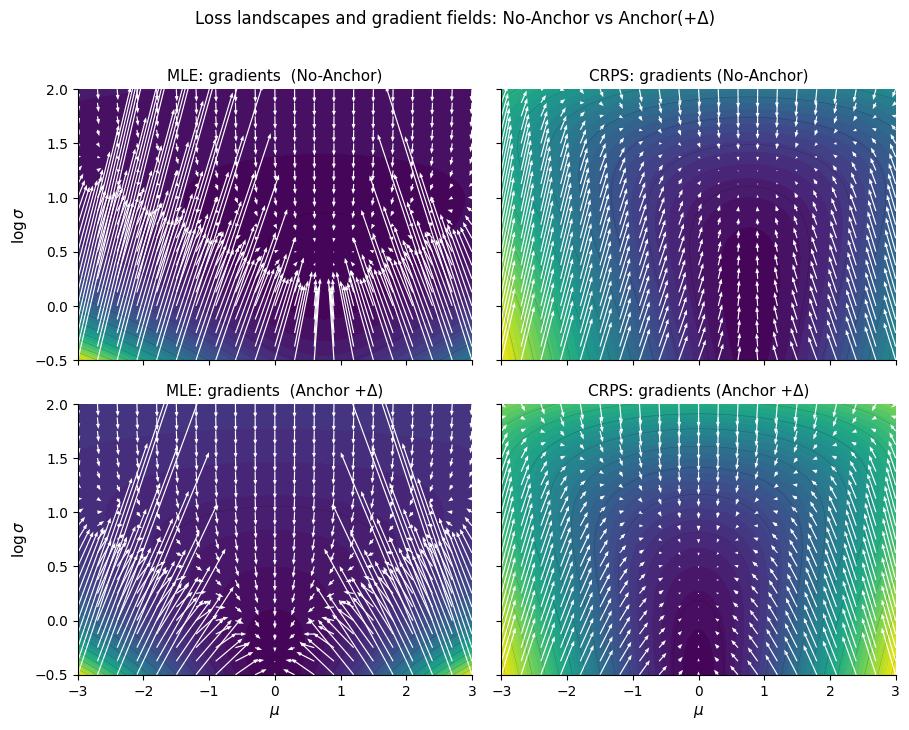

In [37]:
# ============================================================
# Anchor–MoE vs No-Anchor: loss landscapes + gradient fields
# Panels:
#   (TL) MLE, No-Anchor           (TR) CRPS, No-Anchor
#   (BL) MLE, Anchor(+Δ)          (BR) CRPS, Anchor(+Δ)
# Saves: "figure_anchor_moe_gradfields_MLE_CRPS.pdf"
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt, pi
from scipy.special import erf

SQRT2PI = np.sqrt(2.0 * np.pi)
SQRTPI  = np.sqrt(np.pi)

# ------------------ 1) Toy data + anchor predictions ------------------
SEED = 7
rng = np.random.RandomState(SEED)

# x: 中间密集，两端稀疏
n = 700
mix_w = np.array([0.2, 0.6, 0.2])
mix_mu = np.array([-1.1, 0.0, 1.1])
mix_sd = np.array([0.22, 0.35, 0.22])
comp = rng.choice(3, size=n, p=mix_w)
x = rng.normal(mix_mu[comp], mix_sd[comp]).astype(np.float32)
x = np.clip(x, -1.5, 1.5).reshape(-1, 1)

# piecewise-linear + plateau mean
l, r = -0.5, 0.5
mu0, kL, kR = 0.8, 3.5, 3.5
true_mean = np.where(
    x[:, 0] < l, mu0 + kL*(x[:, 0]-l),
    np.where(x[:, 0] <= r, mu0, mu0 + kR*(x[:, 0]-r))
).astype(np.float32)

# heteroscedastic noise: center small, tails large
sigma = (0.06
         + 0.9*np.clip(np.abs(x[:, 0]) - 0.2, 0, None)
         + 0.7*np.clip(np.abs(x[:, 0]) - 1.0, 0, None)).astype(np.float32)
y = true_mean + rng.normal(0.0, sigma)

# Anchor: smooth GBDT
Xtr, Xva, ytr, yva = train_test_split(x, y, test_size=0.2, random_state=SEED)
gbdt_full = GradientBoostingRegressor(
    n_estimators=2600, learning_rate=0.03, max_depth=2, subsample=1.0, random_state=SEED
).fit(Xtr, ytr)
rmse_path = [np.sqrt(mean_squared_error(yva, p)) for p in gbdt_full.staged_predict(Xva)]
best_it = int(np.argmin(rmse_path)) + 1
gbdt_anchor = GradientBoostingRegressor(
    n_estimators=best_it, learning_rate=0.03, max_depth=2, subsample=1.0, random_state=SEED
).fit(x, y)
a = gbdt_anchor.predict(x).astype(np.float64)   # anchor a_i

# ------------------ 2) Helpers ------------------
def Phi(z):  # CDF
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def phi(z):  # PDF
    return np.exp(-0.5 * z**2) / SQRT2PI

# ------------------ 3) Build surfaces on a grid ------------------
# grid ranges similar to NGBoost fig
MU_MIN, MU_MAX = -3.0, 3.0        # for μ (no-anchor) or δ (anchor)
T_MIN,  T_MAX  = -0.5, 2.0        # for t = log σ
NX, NY = 81, 81

mus   = np.linspace(MU_MIN, MU_MAX, NX)
tgrid = np.linspace(T_MIN, T_MAX, NY)
MU, T = np.meshgrid(mus, tgrid)
SIG   = np.exp(T)

def surface_and_field(y_vec, anchor_mean=None, use_anchor=False, scoring="mle"):
    """
    y_vec: 1D (n,) 观测
    anchor_mean: 标量或 (n,) 向量（带 anchor 时使用）
    use_anchor: True=μ_total=μ_grid+anchor ; False=μ_total=μ_grid
    scoring: "mle" (== NLL up to const) 或 "crps"
    返回: L, U, V  (均为 shape=NY×NX)，其中 U,V 是"下降方向" (-∇)
    """
    y = np.asarray(y_vec, dtype=np.float64).reshape(-1, 1, 1)   # (n,1,1)
    MU3  = MU[None, :, :]                                       # (1,NY,NX)
    SIG3 = SIG[None, :, :]

    if use_anchor:
        if anchor_mean is None:
            raise ValueError("use_anchor=True 时必须提供 anchor_mean")
        A = np.asarray(anchor_mean, dtype=np.float64)
        A3 = A if A.ndim == 0 else A.reshape(-1, 1, 1)
        MU_eff = MU3 + A3
    else:
        MU_eff = MU3

    s = scoring.lower()
    if s in ("mle", "nll"):
        # MLE == 最小化 NLL（差常数 0.5*log(2π)，不影响梯度和等高线）
        res = y - MU_eff
        L = np.log(SIG3) + 0.5*(res**2)/(SIG3**2) + 0.5*np.log(2.0*np.pi)
        L = L.mean(axis=0)
        # ∂L/∂μ, ∂L/∂t (t=log σ)
        dL_dmu = ((MU_eff - y)/(SIG3**2)).mean(axis=0)
        dL_dt  = (1.0 - (res**2)/(SIG3**2)).mean(axis=0)
        U, V = -dL_dmu, -dL_dt

    elif s == "crps":
        # CRPS(N(μ,σ),y) = σ [ z(2Φ-1) + 2φ - 1/√π ]， z=(y-μ)/σ
        z = (y - MU_eff) / SIG3
        Phi_z = Phi(z)
        phi_z = phi(z)
        L = SIG3 * ( z*(2.0*Phi_z - 1.0) + 2.0*phi_z - 1.0/SQRTPI )
        L = L.mean(axis=0)
        # ∂CRPS/∂μ = -(2Φ(z)-1)
        # ∂CRPS/∂σ = 2φ(z) - 1/√π - z(2Φ(z)-1)  ==>  ∂/∂t = σ * ∂/∂σ
        dL_dmu = (-(2.0*Phi_z - 1.0)).mean(axis=0)
        dL_dt  = (SIG3 * (2.0*phi_z - 1.0/SQRTPI - z*(2.0*Phi_z - 1.0))).mean(axis=0)
        U, V = -dL_dmu, -dL_dt
    else:
        raise ValueError("scoring must be 'mle' or 'crps'.")

    return L, U, V

# compute all four panels
L_mle_no,  U_mle_no,  V_mle_no  = surface_and_field(y, None, False, "mle")
L_crps_no, U_crps_no, V_crps_no = surface_and_field(y, None, False, "crps")
L_mle_an,  U_mle_an,  V_mle_an  = surface_and_field(y, a,    True,  "mle")
L_crps_an, U_crps_an, V_crps_an = surface_and_field(y, a,    True,  "crps")

# ------------------ 4) Plot ------------------
fig, axs = plt.subplots(2, 2, figsize=(9.2, 7.4), sharex=True, sharey=True)

def panel(ax, L, U, V, title, xlabel=False, ylabel=False):
    cf = ax.contourf(MU, T, L, levels=40, cmap="viridis")
    cs = ax.contour(MU, T, L, levels=12, colors="k", linewidths=0.25, alpha=0.35)
    step = 4  # downsample arrows for clarity
    ax.quiver(MU[::step, ::step], T[::step, ::step],
              U[::step, ::step], V[::step, ::step],
              color="w", scale=28, width=0.003, headwidth=3.2, headlength=4.2)
    ax.set_title(title, fontsize=11)
    if xlabel:
        ax.set_xlabel(r"$\mu$", fontsize=11)
    if ylabel:
        ax.set_ylabel(r"$\log \sigma$", fontsize=11)
    ax.set_xlim(MU_MIN, MU_MAX); ax.set_ylim(T_MIN, T_MAX)
    for sp in ["top", "right"]:
        ax.spines[sp].set_visible(False)

panel(axs[0,0], L_mle_no,  U_mle_no,  V_mle_no,  "MLE: gradients  (No-Anchor)", ylabel=True)
panel(axs[0,1], L_crps_no, U_crps_no, V_crps_no, "CRPS: gradients (No-Anchor)")
panel(axs[1,0], L_mle_an,  U_mle_an,  V_mle_an,  "MLE: gradients  (Anchor +Δ)", xlabel=True, ylabel=True)
panel(axs[1,1], L_crps_an, U_crps_an, V_crps_an, "CRPS: gradients (Anchor +Δ)", xlabel=True)

fig.suptitle("Loss landscapes and gradient fields: No-Anchor vs Anchor(+Δ)", y=0.98, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.965])
plt.savefig("figure_anchor_moe_gradfields_MLE_CRPS.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()